<a href="https://colab.research.google.com/github/jarekwan/jarwan_projekt/blob/main/Projekt1_brudnopis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BIBLIOTEKI I POBRANIE JSON Z RESTCOUNTRIES

In [1]:
import requests      # biblioteka do pobierania danych z API
import pandas as pd  # biblioteka do pracy z tabelami (DataFrame)
import json
from typing import List, Dict, Optional
from pydantic import BaseModel, ValidationError  # Pydantic do walidacji danych
# adres API RestCountries z wybranymi polami (max 10 na raz)
url = "https://restcountries.com/v3.1/all?fields=name,capital,region,subregion,population,area,currencies,languages,timezones,flags"

# pobranie danych z API
resp = requests.get(url)


#sprawdzanie surowego jsona
# wypisanie statusu odpowiedzi (200 = OK)
print("Status:", resp.status_code)

print(len(resp.text))#po nim wstawiam PYDANTIC
print(resp.text[:500])

# czy zaweira kluczowe frazy
print("name" in resp.text)
print("population" in resp.text)


Status: 200
170660
[{"flags":{"png":"https://flagcdn.com/w320/jm.png","svg":"https://flagcdn.com/jm.svg","alt":"The flag of Jamaica is divided by a gold diagonal cross into four alternating triangular areas of green at the top and bottom, and black on the hoist and fly sides"},"name":{"common":"Jamaica","official":"Jamaica","nativeName":{"eng":{"official":"Jamaica","common":"Jamaica"},"jam":{"official":"Jamaica","common":"Jamaica"}}},"currencies":{"JMD":{"name":"Jamaican dollar","symbol":"$"}},"capital":["Kingston
True
True


SPRAWDZANIE CZY JSON POBRAL SIE PRAWIDLOWO

In [2]:
if resp.status_code == 200:
    # konwersja odpowiedzi JSON → Python (lista słowników)
    data = resp.json()
    print(type(data))
    # sprawdź typ pierwszego elementu
    print(type(data[0]))
    # zamiana listy słowników na tabelę Pandas



else:
    # jeśli status ≠ 200, wyświetlamy komunikat błędu
    print("Błąd:", resp.text)

<class 'list'>
<class 'dict'>


SPRAWDZENIE 1SZY ELEMNTOW POSZCZEGOLNYCH POL JAKIEGO SA TYPU

In [3]:
print(type(data[0]["name"]))
print(type(data[0]["capital"]))
print(type(data[0]["region"]))
print(type(data[0]["subregion"]))
print(type(data[0]["population"]))
print(type(data[0]["area"]))
print(type(data[0]["currencies"]))
print(type(data[0]["languages"]))
print(type(data[0]["timezones"]))
print(type(data[0]["flags"]))


<class 'dict'>
<class 'list'>
<class 'str'>
<class 'str'>
<class 'int'>
<class 'float'>
<class 'dict'>
<class 'dict'>
<class 'list'>
<class 'dict'>


SPRAWDZENIE WEWNATRZ WSZYSTKICH ZAGNIEZDZEN ILE ICH JEST I JAKIEGO SA TYPU ZA POMACA REKURENCYJNEJ FUNKCJI

In [4]:
def describe(val):
    # jeśli to słownik
    if isinstance(val, dict):
        return {k: describe(v) for k, v in val.items()}
    # jeśli to lista
    elif isinstance(val, list) and len(val) > 0:
        return {"list_of": describe(val[0])}
    # proste typy
    else:
        return type(val).__name__

# użycie:
sample = data[0]  # pierwszy rekord z JSON
field_types = {k: describe(v) for k, v in sample.items()}

print(field_types)

{'flags': {'png': 'str', 'svg': 'str', 'alt': 'str'}, 'name': {'common': 'str', 'official': 'str', 'nativeName': {'eng': {'official': 'str', 'common': 'str'}, 'jam': {'official': 'str', 'common': 'str'}}}, 'currencies': {'JMD': {'name': 'str', 'symbol': 'str'}}, 'capital': {'list_of': 'str'}, 'region': 'str', 'subregion': 'str', 'languages': {'eng': 'str', 'jam': 'str'}, 'area': 'float', 'population': 'int', 'timezones': {'list_of': 'str'}}


PRZEDSTAWIENIE STRURY I TYPY WEW. JSON PLIKU W SPOSOB UMOZLIWJACA NAOCZNA WERYFIKACJE

In [5]:


print(json.dumps(field_types, indent=2))


{
  "flags": {
    "png": "str",
    "svg": "str",
    "alt": "str"
  },
  "name": {
    "common": "str",
    "official": "str",
    "nativeName": {
      "eng": {
        "official": "str",
        "common": "str"
      },
      "jam": {
        "official": "str",
        "common": "str"
      }
    }
  },
  "currencies": {
    "JMD": {
      "name": "str",
      "symbol": "str"
    }
  },
  "capital": {
    "list_of": "str"
  },
  "region": "str",
  "subregion": "str",
  "languages": {
    "eng": "str",
    "jam": "str"
  },
  "area": "float",
  "population": "int",
  "timezones": {
    "list_of": "str"
  }
}


SPRAWDZAM JAKA WERSJE PYDANTIC MAM

In [6]:
import pydantic
print(pydantic.VERSION)

2.11.7


WALIDACJA Z PYDANTIC (weryfikacja czy typy i klasy sa prawidlowe)

In [7]:

from typing import List, Optional, Dict
from pydantic import BaseModel, ValidationError

class Flags(BaseModel):
    png: str
    svg: str
    alt: str

class NativeNameEntry(BaseModel):
    official: str
    common: str

class Name(BaseModel):
    common: str
    official: str
    nativeName: Optional[Dict[str, NativeNameEntry]]

class Currency(BaseModel):
    name: str
    symbol: str



class Country(BaseModel):
    name: Name
    flags: Flags
    currencies: Optional[Dict[str, Currency]]  # This line uses Currency
    capital: List[str]
    region: str
    subregion: Optional[str]
    languages: Dict[str, str]
    area: Optional[float]
    population: int
    timezones: List[str]


# Usage:
try:
    countries = [Country(**item) for item in data]
    print(f"Validated {len(countries)} countries successfully")
except ValidationError as e:
    print(f"Validation error: {e}")

Validated 250 countries successfully


SPRAWDZAM CZY W OPCJONALNYCH FIELDS SA JAKIEKOLWIEK BRAKI DANYCH

In [ ]:
# Get all optional fields from your model
optional_fields = []
for field_name, field_info in Country.model_fields.items():
    if not field_info.is_required():
        optional_fields.append(field_name)

print(f"Optional fields: {optional_fields}")

# Check which optional fields are missing in each country
for i, item in enumerate(data):
    missing_optional = []
    for field in optional_fields:
        if field not in item or item[field] is None:
            missing_optional.append(field)

    if missing_optional:
        print(f"Country {i}: Missing optional data: {missing_optional}")


Optional fields: []


In [ ]:
for field_name, field_info in Country.model_fields.items():
    print(f"{field_name}: required={field_info.is_required()}")

name: required=True
flags: required=True
currencies: required=True
capital: required=True
region: required=True
subregion: required=True
languages: required=True
area: required=True
population: required=True
timezones: required=True


In [ ]:
# 2. Serializacja → zapis danych do pliku JSON
with open("countries.json", "w") as f:   # "w" = write = zapis
    json.dump(data, f, indent=2)         # indent=2 = czytelne formatowanie
print("Dane zapisane do pliku countries.json")

# 3. Odczyt JSON z pliku
with open("countries.json", "r") as f:   # "r" = read = odczyt
    loaded_data = json.load(f)

print(f"Odczytano {len(loaded_data)} rekordów z pliku")

# 4. Konwersja do DataFrame
df = pd.json_normalize(loaded_data)

print("DataFrame utworzony:", df.shape)
print(df.head(3))  # podgląd pierwszych wierszy


Dane zapisane do pliku countries.json
Odczytano 250 rekordów z pliku
DataFrame utworzony: (250, 795)
      capital    region        subregion      area  population    timezones  \
0  [Kingston]  Americas        Caribbean   10991.0     2961161  [UTC-05:00]   
1    [Moroni]    Africa   Eastern Africa    1862.0      869595  [UTC+03:00]   
2    [Harare]    Africa  Southern Africa  390757.0    14862927  [UTC+02:00]   

                         flags.png                   flags.svg  \
0  https://flagcdn.com/w320/jm.png  https://flagcdn.com/jm.svg   
1  https://flagcdn.com/w320/km.png  https://flagcdn.com/km.svg   
2  https://flagcdn.com/w320/zw.png  https://flagcdn.com/zw.svg   

                                           flags.alt name.common  ...  \
0  The flag of Jamaica is divided by a gold diago...     Jamaica  ...   
1  The flag of Comoros is composed of four equal ...     Comoros  ...   
2  The flag of Zimbabwe is composed of seven equa...    Zimbabwe  ...   

  name.nativeName.mfe.co

WALIDACJA RECZNA W DATAFRAME

In [ ]:
# 5. Walidacja ręczna typu danych

# Sprawdzenie czy wszystkie wartości w kolumnie "population" to int
population_type_check = df["population"].apply(lambda x: isinstance(x, int))

# Sprawdzenie czy wszystkie wartości w kolumnie "area" to int lub float
area_type_check = df["area"].apply(lambda x: isinstance(x, (int, float)))

# Wiersze z błędnym typem w "population"
invalid_population = df[~population_type_check]
print(f"Liczba rekordów z niepoprawnym population: {len(invalid_population)}")
if not invalid_population.empty:
    print(invalid_population[["name.common", "population"]])

# Wiersze z błędnym typem w "area"
invalid_area = df[~area_type_check]
print(f"Liczba rekordów z niepoprawnym area: {len(invalid_area)}")
if not invalid_area.empty:
    print(invalid_area[["name.common", "area"]])


Liczba rekordów z niepoprawnym population: 0
Liczba rekordów z niepoprawnym area: 0


CZYSZCZENIE DANYCH

Sprawdzenie braków (NaN) w całym DataFrame

In [ ]:
print("\n6. Czyszczenie danych\n")

# 6.1 Sprawdzenie braków (NaN) w całym DataFrame
print("Braki danych (NaN) w kolumnach:")
print(df.isna().sum())#
print(len(df.isna().sum()))## sprawdzenie ilosci wierszy
missing = df.isna().sum()# pokazanie probek sprawdzenia
print(missing[missing > 0])# pokazanie tych brakujacych (ale nie calej listy)



6. Czyszczenie danych

Braki danych (NaN) w kolumnach:
capital                           0
region                            0
subregion                         0
area                              0
population                        0
                               ... 
currencies.KYD.symbol           249
name.nativeName.bar.official    249
name.nativeName.bar.common      249
currencies.LRD.name             249
currencies.LRD.symbol           249
Length: 795, dtype: int64
795
name.nativeName.eng.official    160
name.nativeName.eng.common      160
name.nativeName.jam.official    249
name.nativeName.jam.common      249
currencies.JMD.name             249
                               ... 
currencies.KYD.symbol           249
name.nativeName.bar.official    249
name.nativeName.bar.common      249
currencies.LRD.name             249
currencies.LRD.symbol           249
Length: 784, dtype: int64


WYSWIETLENIE WSZYSTKICH WIERSZY GDZIE SA BRAKI

In [ ]:
import pandas as pd

pd.set_option("display.max_rows", None)   # pokaż wszystkie kolumny
print(missing[missing > 0])
pd.reset_option("display.max_rows")       # przywróć domyślne
missing[missing > 0].to_csv("braki.csv")


name.nativeName.eng.official    160
name.nativeName.eng.common      160
name.nativeName.jam.official    249
name.nativeName.jam.common      249
currencies.JMD.name             249
currencies.JMD.symbol           249
languages.eng                   159
languages.jam                   249
name.nativeName.ara.official    225
name.nativeName.ara.common      225
name.nativeName.fra.official    204
name.nativeName.fra.common      204
name.nativeName.zdj.official    249
name.nativeName.zdj.common      249
currencies.KMF.name             249
currencies.KMF.symbol           249
languages.ara                   225
languages.fra                   204
languages.zdj                   249
name.nativeName.bwg.official    249
name.nativeName.bwg.common      249
name.nativeName.kck.official    249
name.nativeName.kck.common      249
name.nativeName.khi.official    249
name.nativeName.khi.common      249
name.nativeName.ndc.official    249
name.nativeName.ndc.common      249
name.nativeName.nde.official

 Liczba kolumn zawierających przynajmniej jeden brak

In [ ]:
# Liczba kolumn zawierających przynajmniej jeden brak
num_cols_with_na = (df.isna().sum() > 0).sum()
num_cols_without_na = (df.isna().sum() == 0).sum()

print(f"\n📊 Liczba kolumn z brakami: {num_cols_with_na}")
print(f"📊 Liczba kolumn bez braków: {num_cols_without_na}")



📊 Liczba kolumn z brakami: 784
📊 Liczba kolumn bez braków: 11


Liczba wierszy zawierających przynajmniej jeden brak

In [ ]:
# Liczba wierszy zawierających przynajmniej jeden brak
num_rows_with_na = df.isna().any(axis=1).sum()
num_rows_without_na = (~df.isna().any(axis=1)).sum()

print(f"\n📈 Liczba wierszy z brakami: {num_rows_with_na}")
print(f"📈 Liczba wierszy bez braków: {num_rows_without_na}")



📈 Liczba wierszy z brakami: 250
📈 Liczba wierszy bez braków: 0


In [ ]:
# Oblicz procent braków w każdej kolumnie
missing_percent = (df.isna().sum() / len(df) * 100).sort_values(ascending=False)

# Pokaż kolumny z największą liczbą braków na początku
print("\n🔍 Procent braków w kolumnach (posortowane malejąco):")
print(missing_percent)

# Opcjonalnie: zapisz do pliku CSV, żeby przejrzeć w Excelu
missing_percent.to_csv("braki_procent.csv")



🔍 Procent braków w kolumnach (posortowane malejąco):
currencies.LRD.symbol           99.6
currencies.LRD.name             99.6
name.nativeName.bar.common      99.6
name.nativeName.bar.official    99.6
currencies.KYD.symbol           99.6
                                ... 
population                       0.0
area                             0.0
subregion                        0.0
region                           0.0
capital                          0.0
Length: 795, dtype: float64


In [ ]:
# --- 6.2 Usuwanie kolumn z ponad 89% braków ---

# Ustal próg procentowy
threshold = 89

# Wybierz kolumny do usunięcia
cols_to_drop = missing_percent[missing_percent > threshold].index.tolist()

print(f"\n🗑️ Usuwam {len(cols_to_drop)} kolumn z ponad {threshold}% braków")
print("Kolumny do usunięcia:")
print(cols_to_drop)

# Usuń te kolumny z DataFrame
df = df.drop(columns=cols_to_drop)

print(f"✅ Pozostało kolumn po usunięciu: {df.shape[1]}")


🗑️ Usuwam 776 kolumn z ponad 89% braków
Kolumny do usunięcia:
['currencies.LRD.symbol', 'currencies.LRD.name', 'name.nativeName.bar.common', 'name.nativeName.bar.official', 'currencies.KYD.symbol', 'currencies.KYD.name', 'currencies.KES.name', 'languages.kaz', 'currencies.KZT.symbol', 'currencies.KZT.name', 'name.nativeName.kaz.common', 'name.nativeName.kaz.official', 'currencies.HNL.symbol', 'currencies.HNL.name', 'currencies.UGX.symbol', 'currencies.UGX.name', 'languages.sag', 'name.nativeName.sag.common', 'name.nativeName.sag.official', 'languages.run', 'currencies.BIF.symbol', 'currencies.BIF.name', 'name.nativeName.ndc.common', 'name.nativeName.ndc.official', 'name.nativeName.khi.common', 'name.nativeName.khi.official', 'name.nativeName.kck.common', 'name.nativeName.kck.official', 'name.nativeName.bwg.common', 'name.nativeName.bwg.official', 'languages.zdj', 'currencies.KMF.symbol', 'currencies.KMF.name', 'name.nativeName.zdj.common', 'name.nativeName.zdj.official', 'name.nativeN

In [ ]:
# Zapisz listę pozostałych kolumn do pliku CSV
df.columns.to_series().to_csv("pozostale_kolumny.csv", index=False)

print("📁 Zapisano listę pozostałych kolumn do pliku 'pozostale_kolumny.csv'")

📁 Zapisano listę pozostałych kolumn do pliku 'pozostale_kolumny.csv'


In [ ]:
import pandas as pd

# Kolumny do sprawdzenia
check_cols = [
    'currencies.EUR.name', 'currencies.EUR.symbol',
    'name.nativeName.fra.official', 'name.nativeName.fra.common', 'languages.fra',
    'name.nativeName.eng.official', 'name.nativeName.eng.common', 'languages.eng'
]

# Sprawdzenie unikalnych typów danych dla każdej kolumny
type_checks = {}

for col in check_cols:
    if col in df.columns:
        unique_types = df[col].dropna().map(type).unique()
        type_checks[col] = [t.__name__ for t in unique_types]
    else:
        type_checks[col] = ['Column not found']

# Konwersja do DataFrame
type_checks_df = pd.DataFrame.from_dict(type_checks, orient='index', columns=['Types'])

# Wyświetlenie wyników
print("\n✅ Typy danych w sprawdzanych kolumnach:")
print(type_checks_df)

# Zapis do pliku CSV (opcjonalnie)
type_checks_df.to_csv("typy_danych_sprawdzane.csv")
print("📁 Zapisano typy danych do pliku: typy_danych_sprawdzane.csv")





✅ Typy danych w sprawdzanych kolumnach:
                             Types
currencies.EUR.name            str
currencies.EUR.symbol          str
name.nativeName.fra.official   str
name.nativeName.fra.common     str
languages.fra                  str
name.nativeName.eng.official   str
name.nativeName.eng.common     str
languages.eng                  str
📁 Zapisano typy danych do pliku: typy_danych_sprawdzane.csv


In [ ]:
# Wypełnianie braków zgodnie z ustalonymi zasadami

# 1. currencies.EUR.* → "not EUR"
df['currencies.EUR.name'] = df['currencies.EUR.name'].fillna("not EUR")
df['currencies.EUR.symbol'] = df['currencies.EUR.symbol'].fillna("not EUR")

# 2. name.nativeName.fra.* + languages.fra → "nonFR"
df['name.nativeName.fra.official'] = df['name.nativeName.fra.official'].fillna("nonFR")
df['name.nativeName.fra.common'] = df['name.nativeName.fra.common'].fillna("nonFR")
df['languages.fra'] = df['languages.fra'].fillna("nonFR")

# 3. name.nativeName.eng.* + languages.eng → "nonENG"
df['name.nativeName.eng.official'] = df['name.nativeName.eng.official'].fillna("nonENG")
df['name.nativeName.eng.common'] = df['name.nativeName.eng.common'].fillna("nonENG")
df['languages.eng'] = df['languages.eng'].fillna("nonENG")

# Sprawdzenie, czy zostały jeszcze jakieś braki w tych kolumnach
remaining_na = df[[
    'currencies.EUR.name', 'currencies.EUR.symbol',
    'name.nativeName.fra.official', 'name.nativeName.fra.common', 'languages.fra',
    'name.nativeName.eng.official', 'name.nativeName.eng.common', 'languages.eng'
]].isna().sum()

remaining_na


,0
currencies.EUR.name,0
currencies.EUR.symbol,0
name.nativeName.fra.official,0
name.nativeName.fra.common,0
languages.fra,0
name.nativeName.eng.official,0
name.nativeName.eng.common,0
languages.eng,0


Sprawdzenie braków tylko w tych kolumnach (zwraca liczbę braków):

In [ ]:
df[[
    'currencies.EUR.name', 'currencies.EUR.symbol',
    'name.nativeName.fra.official', 'name.nativeName.fra.common', 'languages.fra',
    'name.nativeName.eng.official', 'name.nativeName.eng.common', 'languages.eng'
]].isna().sum()


,0
currencies.EUR.name,0
currencies.EUR.symbol,0
name.nativeName.fra.official,0
name.nativeName.fra.common,0
languages.fra,0
name.nativeName.eng.official,0
name.nativeName.eng.common,0
languages.eng,0


Sprawdzenie, czy jakikolwiek NaN występuje:

In [ ]:
df[[
    'currencies.EUR.name', 'currencies.EUR.symbol',
    'name.nativeName.fra.official', 'name.nativeName.fra.common', 'languages.fra',
    'name.nativeName.eng.official', 'name.nativeName.eng.common', 'languages.eng'
]].isna().any()


,0
currencies.EUR.name,False
currencies.EUR.symbol,False
name.nativeName.fra.official,False
name.nativeName.fra.common,False
languages.fra,False
name.nativeName.eng.official,False
name.nativeName.eng.common,False
languages.eng,False


Filtruj i wyświetl wiersze, gdzie nadal coś jest NaN:

In [ ]:
filtered = df[
    df[[
        'currencies.EUR.name', 'currencies.EUR.symbol',
        'name.nativeName.fra.official', 'name.nativeName.fra.common', 'languages.fra',
        'name.nativeName.eng.official', 'name.nativeName.eng.common', 'languages.eng'
    ]].isna().any(axis=1)
]
print("Liczba wierszy z brakami w wybranych kolumnach:", len(filtered))



Liczba wierszy z brakami w wybranych kolumnach: 0


Liczba kolumn z jakimikolwiek brakami

In [ ]:
kolumny_z_brakami = df.isna().sum()
kolumny_z_brakami = kolumny_z_brakami[kolumny_z_brakami > 0]

print(f"📊 Liczba kolumn z brakami: {len(kolumny_z_brakami)}")
if not kolumny_z_brakami.empty:
    print("🔍 Kolumny z brakami:")
    print(kolumny_z_brakami)
else:
    print("✅ Brak kolumn z brakami.")


📊 Liczba kolumn z brakami: 0
✅ Brak kolumn z brakami.


Liczba wierszy z jakimikolwiek brakami

In [ ]:
wiersze_z_brakami = df[df.isna().any(axis=1)]
print(f"\n📈 Liczba wierszy z brakami: {len(wiersze_z_brakami)}")
if not wiersze_z_brakami.empty:
    print("🔍 Przykładowe wiersze z brakami:")
    print(wiersze_z_brakami.head(3))
else:
    print("✅ Brak wierszy z brakami.")



📈 Liczba wierszy z brakami: 0
✅ Brak wierszy z brakami.


. Czy cały DataFrame jest wolny od braków?

In [ ]:
if df.isna().any().any():
    print("\n❌ Wciąż są braki w danych.")
else:
    print("\n✅ DataFrame jest całkowicie wolny od braków.")



✅ DataFrame jest całkowicie wolny od braków.


STATYSTYKI W PANDAS

In [ ]:
# Wybór tylko kolumn liczbowych
numeric_cols = df.select_dtypes(include=['number']).columns
print(f"📊 Kolumny liczbowe: {list(numeric_cols)}")

# Pełny opis statystyczny
print("\n📈 Statystyki opisowe (describe):")
print(df[numeric_cols].describe())

# Średnia
print("\n🔢 Średnie wartości (.mean()):")
print(df[numeric_cols].mean())

# Mediana
print("\n🔸 Mediany (.median()):")
print(df[numeric_cols].median())

# Odchylenie standardowe
print("\n📉 Odchylenie standardowe (.std()):")
print(df[numeric_cols].std())

stats_summary = df[numeric_cols].describe().T
stats_summary.to_csv("statystyki_opisowe.csv")
print("📁 Zapisano statystyki do pliku statystyki_opisowe.csv")


📊 Kolumny liczbowe: ['area', 'population']

📈 Statystyki opisowe (describe):
               area    population
count  2.500000e+02  2.500000e+02
mean   6.005848e+05  3.111089e+07
std    1.909805e+06  1.296673e+08
min    4.400000e-01  0.000000e+00
25%    1.194250e+03  2.210995e+05
50%    6.492950e+04  4.912244e+06
75%    3.727260e+05  1.902577e+07
max    1.709824e+07  1.402112e+09

🔢 Średnie wartości (.mean()):
area          6.005848e+05
population    3.111089e+07
dtype: float64

🔸 Mediany (.median()):
area            64929.5
population    4912244.0
dtype: float64

📉 Odchylenie standardowe (.std()):
area          1.909805e+06
population    1.296673e+08
dtype: float64
📁 Zapisano statystyki do pliku statystyki_opisowe.csv


In [ ]:
Grupowanie i pivot

In [ ]:
# Średnie wartości population i area wg regionu
grouped = df.groupby("region")[["population", "area"]].mean()
print("📊 Średnie wartości population i area wg regionu:")
print(grouped)

# Pivot table: region vs. population (średnia)
pivot = df.pivot_table(values="population", index="region", aggfunc="mean")
print("\n📌 Pivot table: Średnia populacja w regionach:")
print(pivot)


📊 Średnie wartości population i area wg regionu:
             population          area
region                               
Africa     2.308636e+07  5.138715e+05
Americas   1.823172e+07  7.513915e+05
Antarctic  2.860000e+02  2.802422e+06
Asia       9.209190e+07  6.427628e+05
Europe     1.409310e+07  4.355528e+05
Oceania    1.597016e+06  3.153820e+05

📌 Pivot table: Średnia populacja w regionach:
             population
region                 
Africa     2.308636e+07
Americas   1.823172e+07
Antarctic  2.860000e+02
Asia       9.209190e+07
Europe     1.409310e+07
Oceania    1.597016e+06


NumPy – logarytmy, standaryzacja, normalizacja

In [ ]:
import numpy as np

print("\n📦 Punkt 12: NumPy – logarytmy, standaryzacja, normalizacja")

# Logarytmy (log1p = log(x + 1) — unika log(0))
df["log_population"] = np.log1p(df["population"])
df["log_area"] = np.log1p(df["area"])

# Standaryzacja (Z-score): (x - μ) / σ
df["zscore_population"] = (df["population"] - df["population"].mean()) / df["population"].std()
df["zscore_area"] = (df["area"] - df["area"].mean()) / df["area"].std()

# Normalizacja do przedziału [0, 1]
df["norm_population"] = (df["population"] - df["population"].min()) / (df["population"].max() - df["population"].min())
df["norm_area"] = (df["area"] - df["area"].min()) / (df["area"].max() - df["area"].min())

# Podgląd nowych kolumn
print(df[[
    "population", "log_population", "zscore_population", "norm_population"
]].head())

print(df[[
    "area", "log_area", "zscore_area", "norm_area"
]].head())

# Zapis do pliku (opcjonalnie)
df.to_csv("kraje_z_normalizacja.csv", index=False)
print("📁 Dane z logarytmami i normalizacją zapisane do kraje_z_normalizacja.csv")



📦 Punkt 12: NumPy – logarytmy, standaryzacja, normalizacja
   population  log_population  zscore_population  norm_population
0     2961161       14.901092          -0.217092         0.002112
1      869595       13.675784          -0.233222         0.000620
2    14862927       16.514381          -0.125305         0.010600
3       40812       10.616756          -0.239614         0.000029
4     7275556       15.800031          -0.183819         0.005189
       area   log_area  zscore_area  norm_area
0   10991.0   9.304923    -0.308719   0.000643
1    1862.0   7.529943    -0.313499   0.000109
2  390757.0  12.875844    -0.109869   0.022854
3      34.0   3.555348    -0.314457   0.000002
4  236800.0  12.374975    -0.190483   0.013849
📁 Dane z logarytmami i normalizacją zapisane do kraje_z_normalizacja.csv


Wizualizacje w Matplotlib / Seaborn

Histogram population

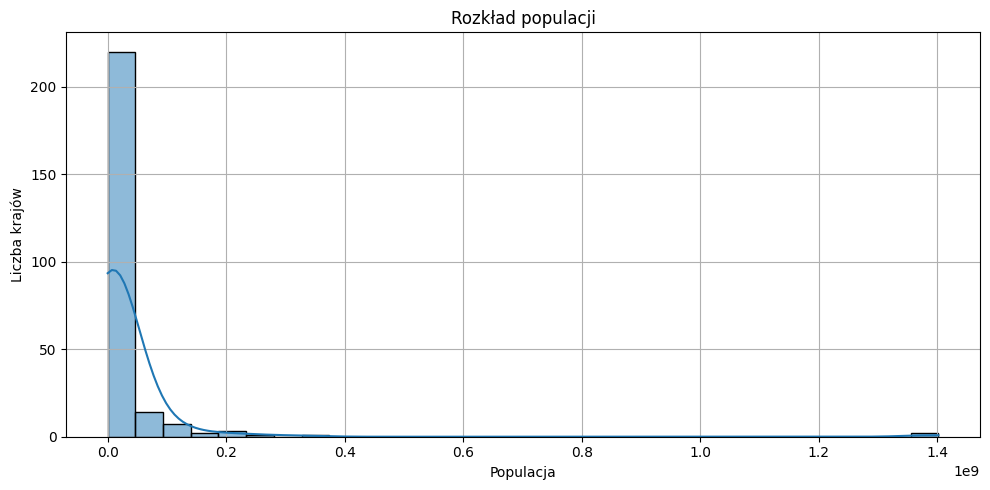

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df["population"], bins=30, kde=True)
plt.title("Rozkład populacji")
plt.xlabel("Populacja")
plt.ylabel("Liczba krajów")
plt.grid(True)
plt.tight_layout()
plt.show()


Boxplot area

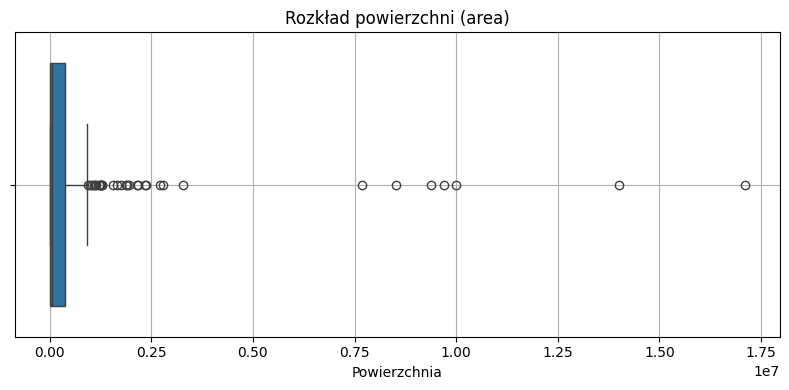

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df["area"])
plt.title("Rozkład powierzchni (area)")
plt.xlabel("Powierzchnia")
plt.grid(True)
plt.tight_layout()
plt.show()


Scatter plot: population vs area

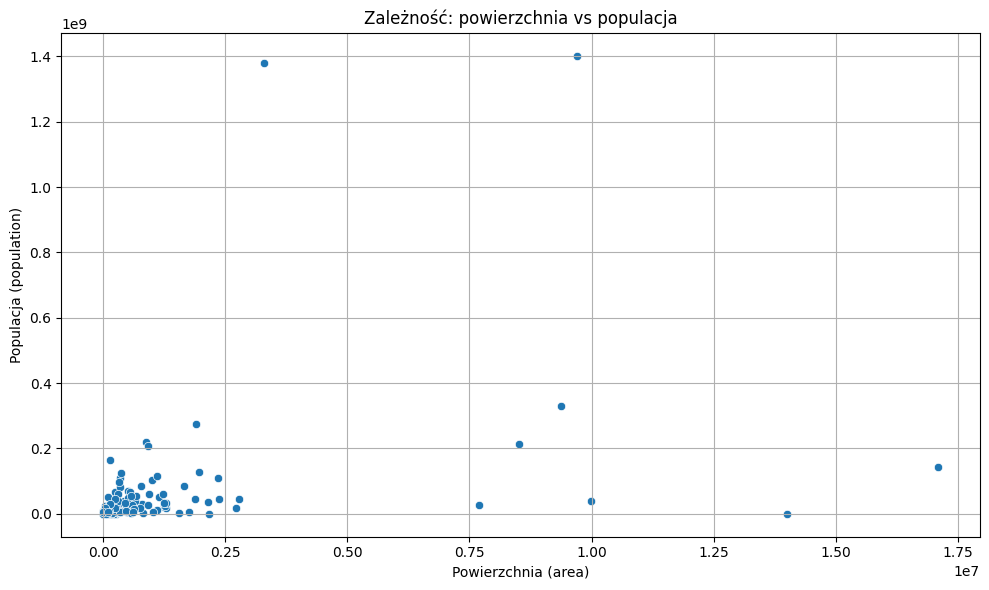

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="area", y="population")
plt.title("Zależność: powierzchnia vs populacja")
plt.xlabel("Powierzchnia (area)")
plt.ylabel("Populacja (population)")
plt.grid(True)
plt.tight_layout()
plt.show()


logarytmiczne skalowanie (jeśli masz ogromne wartości):

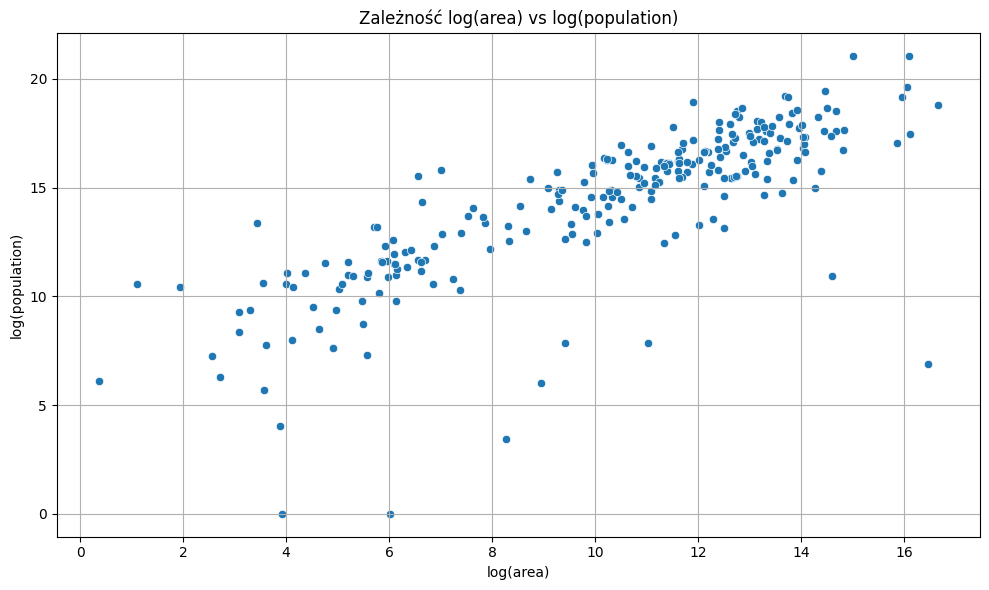

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="log_area", y="log_population")
plt.title("Zależność log(area) vs log(population)")
plt.xlabel("log(area)")
plt.ylabel("log(population)")
plt.grid(True)
plt.tight_layout()
plt.show()


REGEX

Sprawdzenie nazw stolic — tylko litery i spacje

In [ ]:
import re

# Funkcja czyszcząca: zostawia tylko litery i spacje
def clean_text(val):
    if isinstance(val, str):
        return re.sub(r"[^A-Za-z\s]", "", val)
    elif isinstance(val, list):
        return [re.sub(r"[^A-Za-z\s]", "", v) for v in val]
    else:
        return val

# Przykład na kolumnie "capital"
df["capital_clean"] = df["capital"].apply(clean_text)

# Podgląd zmian
print(df[["capital", "capital_clean"]].head(10))


         capital  capital_clean
0     [Kingston]     [Kingston]
1       [Moroni]       [Moroni]
2       [Harare]       [Harare]
3  [Philipsburg]  [Philipsburg]
4    [Vientiane]    [Vientiane]
5         [Riga]         [Riga]
6     [Dushanbe]     [Dushanbe]
7       [London]       [London]
8      [Managua]      [Managua]
9     [Khartoum]     [Khartoum]


Walidacja nazw regionów — tylko litery

In [ ]:
# Regiony, które nie spełniają warunku (tylko litery i spacje)
invalid_regions = df[~df["region"].str.match(r"^[A-Za-z\s]+$")]

print(f"\n🛑 Regiony z niepoprawnym formatem: {len(invalid_regions)}")
if not invalid_regions.empty:
    print(invalid_regions[["name.common", "region"]])



🛑 Regiony z niepoprawnym formatem: 0


Standaryzacja wielkości liter  i zapisanie pliku

In [ ]:
df["capital_clean"] = df["capital_clean"].apply(lambda x: x.title() if isinstance(x, str) else x)


print("📁 Zapisano oczyszczony DataFrame do df_regex_cleaned.csv")

📁 Zapisano oczyszczony DataFrame do df_regex_cleaned.csv


BRUDNOPIS DO TESTOWANIA ISNA I SUM

In [ ]:
# import pandas as pd
# import numpy as np

# # Tworzymy DataFrame z kilkoma brakami danych (NaN)
# df = pd.DataFrame({
#     "country": ["Polska", "Niemcy", "Francja", "Hiszpania"],
#     "population": [38000000, np.nan, 67000000, None],
#     "area": [312679, 357022, None, 505990]
# })

# print("DataFrame:")
# print(df, "\n")

# # Sprawdzenie braków (NaN) w każdej kolumnie
# print("Braki danych (NaN) w kolumnach:")
# print(df.isna().sum(), "\n")

# # Wiersze, gdzie są jakieś braki
# print("Wiersze z brakami danych:")
# print(df[df.isna().any(axis=1)])


BRUDNOPIS REGEX

In [ ]:
# import pandas as pd

# # Mini DataFrame z przykładowymi regionami
# data = {
#     "name.common": ["Country1", "Country2", "Country3", "Country4"],
#     "region": ["Europe", "Asia-1", "North America", "Africa!"]
# }

# df_example = pd.DataFrame(data)

# # Filtrowanie niepoprawnych regionów (tylko litery i spacje dozwolone)
# invalid_regions = df_example[~df_example["region"].str.match(r"^[A-Za-z\s]+$")]

# invalid_regions


,name.common,region
1,Country2,Asia-1
3,Country4,Africa!
